In [1]:
import matplotlib.pyplot as plt
import pandas as pd

df1 = pd.read_csv('dfm-experiments-split-1.csv')
df2 = pd.read_csv('dfm-experiments-split-2.csv')
dfm = pd.read_csv('dfm-opt-experiments.csv')

In [2]:
def filter_solved(df: pd.DataFrame) -> pd.DataFrame:
    df["solved"] = df["lower_bound"] == df["incumbent"]
    return df.query("solved == True", inplace=False)


df1 = filter_solved(df1)
df2 = filter_solved(df2)
dfm = filter_solved(dfm)

In [3]:
df1.shape

(37, 11)

In [4]:
df_n = pd.merge(
    df1[["name", "nodes", "solved"]],
    df2[["name", "nodes", "solved"]],
    on="name", suffixes=('_1', '_2')
)

df_n["solved_both"] = (df_n["solved_1"] & df_n["solved_2"])
df_n = df_n.query("solved_both == True", inplace=False)

In [5]:
df_out = pd.merge(
    dfm[["name", "nodes", "solved"]],
    df_n, on="name"
)
df_out["nodes_fs"] = df_out[["nodes_1", "nodes_2"]].max(axis=1)

In [6]:
df_n.shape

(37, 6)

In [7]:
dfm.shape

(46, 11)

In [8]:
df_out.shape

(34, 9)

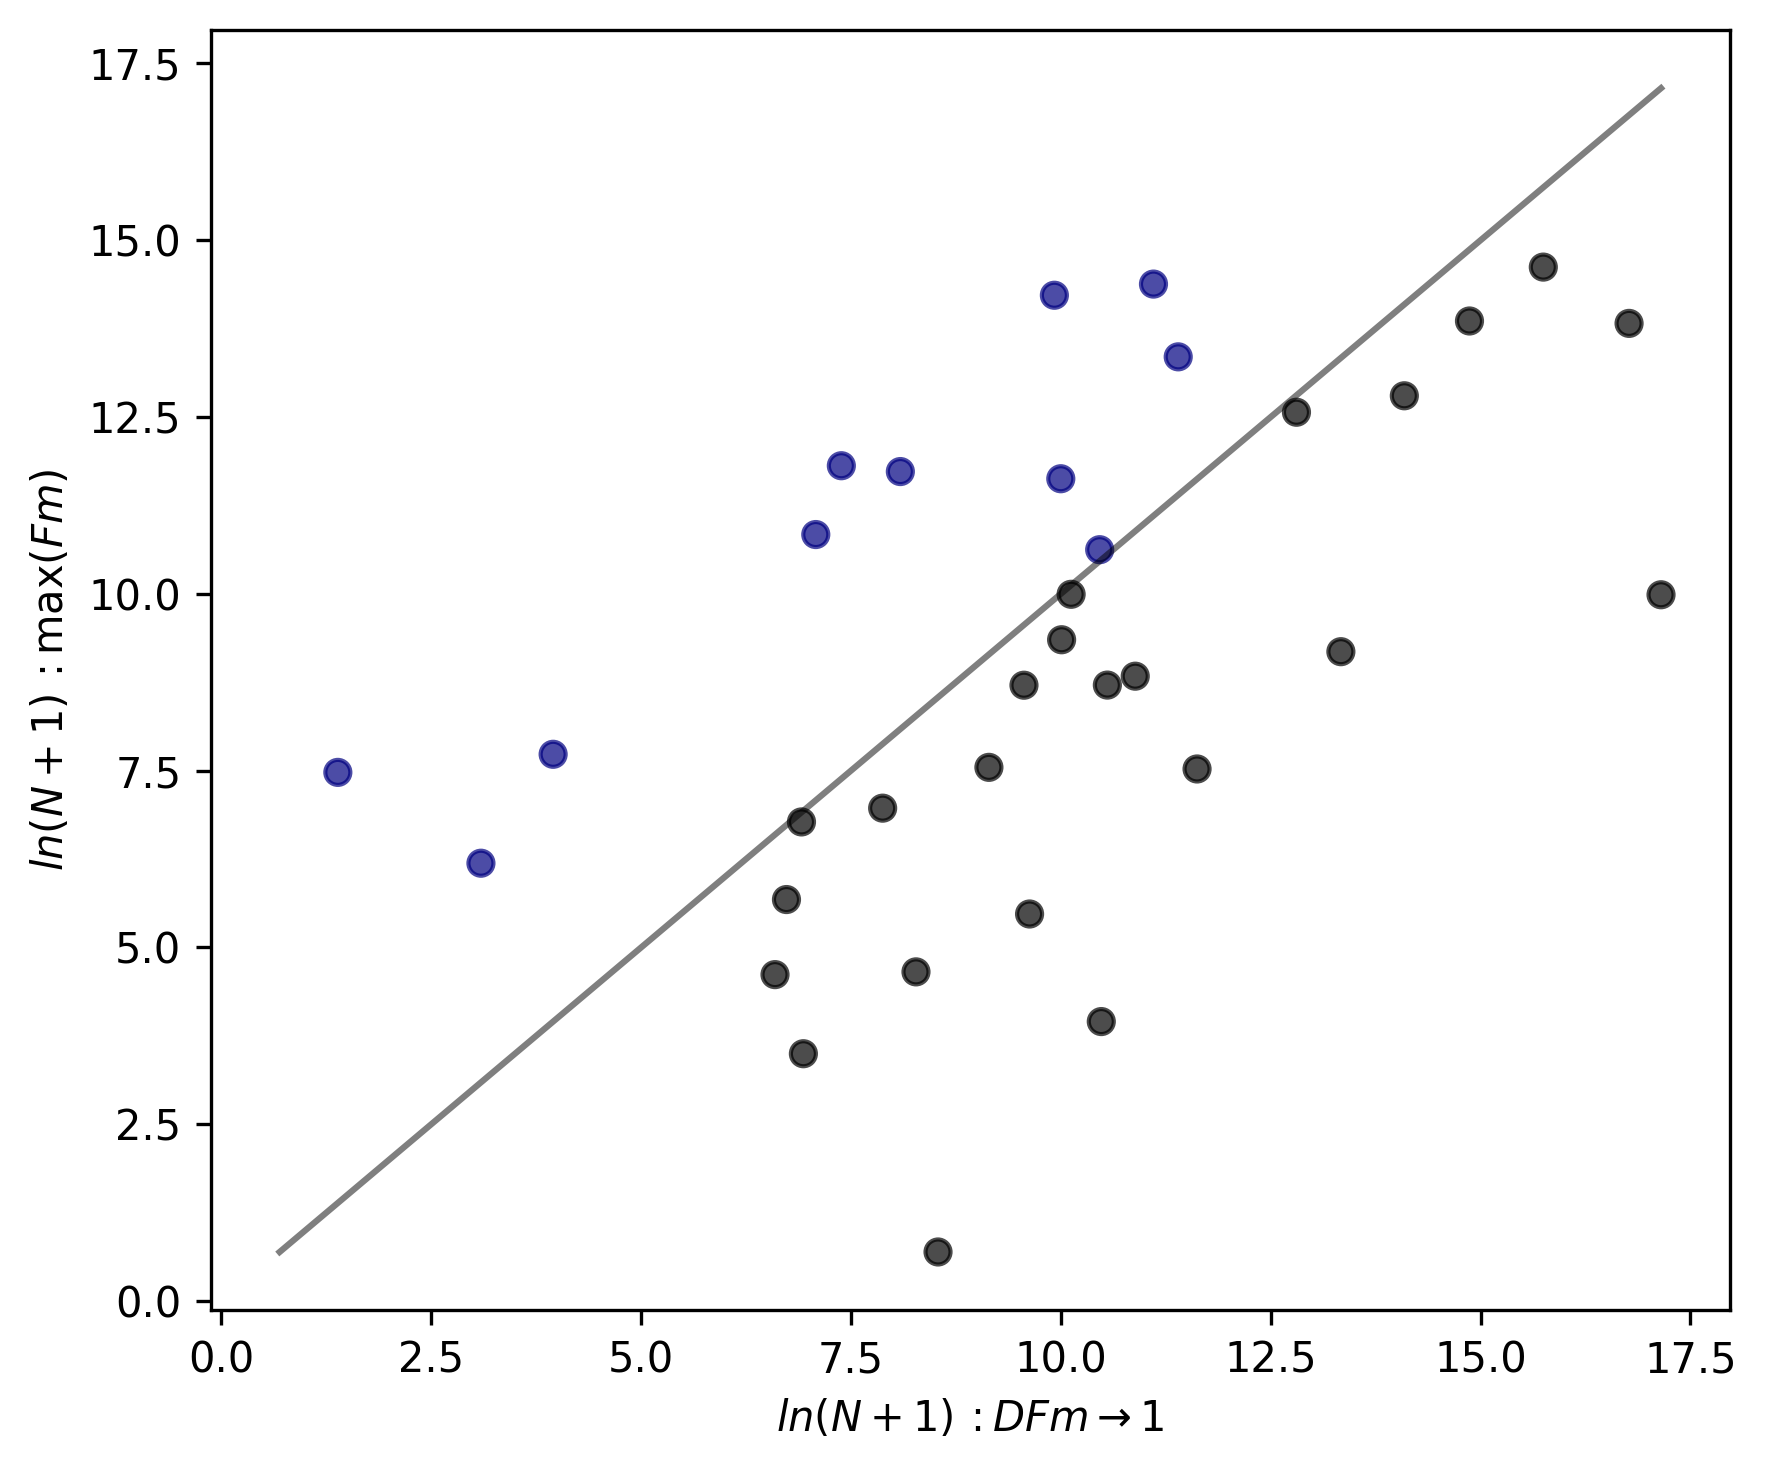

In [9]:
import numpy as np

fig, ax = plt.subplots(figsize=(6, 5), dpi=300)

colors = [
    'navy' if n2 > n5 else 'black'
    for n2, n5 in zip(df_out['nodes_fs'], df_out['nodes'])
]
ax.scatter(
    np.log1p(df_out['nodes']),
    np.log1p(df_out['nodes_fs']),
    alpha=0.7,
    c=colors,
)
min_val = min(
    np.log1p(df_out['nodes'].min()), np.log1p(df_out['nodes_fs'].min())
)
max_val = max(
    np.log1p(df_out['nodes'].max()), np.log1p(df_out['nodes_fs'].max())
)
ax.plot(
    [min_val, max_val],
    [min_val, max_val],
    color='black',
    linestyle='-',
    alpha=0.5,
)
ax.set_xlabel(r'$ln(N + 1) \, : DFm \rightarrow 1 $')
ax.set_ylabel(r'$ln(N + 1) \, : \max(Fm) $')
fig.tight_layout()
plt.savefig('nodes-dfm.pdf', bbox_inches='tight')
plt.show()

## Statistical Analysis

Statistical tests to check if the difference in log-transformed nodes is significantly different from zero.

In [10]:
from scipy import stats

# Calculate differences in log-transformed nodes
log_diff = np.log1p(df_out['nodes_fs']) - np.log1p(df_out['nodes'])

# Perform one-sample t-test (null hypothesis: mean difference = 0)
t_statistic, p_value_t = stats.ttest_1samp(log_diff, 0)

print(f"One-Sample T-Test Results:")
print(f"========================")
print(f"Sample size: {len(log_diff)}")
print(f"Mean difference: {log_diff.mean():.4f}")
print(f"Std deviation: {log_diff.std():.4f}")
print(f"T-statistic: {t_statistic:.4f}")
print(f"P-value: {p_value_t:.6f}")
print(f"\nInterpretation:")
if p_value_t < 0.05:
    if log_diff.mean() > 0:
        print("Split approach explores significantly MORE nodes than DFm (p < 0.05)")
    else:
        print("Split approach explores significantly FEWER nodes than DFm (p < 0.05)")
else:
    print("No significant difference between Split and DFm (p >= 0.05)")

# Perform one-sample sign test (null hypothesis: median difference = 0)
# Sign test counts positive vs negative differences
n_positive = (log_diff > 0).sum()
n_negative = (log_diff < 0).sum()
n_total = n_positive + n_negative  # Exclude zeros

# Binomial test: H0: probability of positive = 0.5
sign_test_result = stats.binomtest(n_positive, n_total, 0.5, alternative='two-sided')

print(f"\n\nOne-Sample Sign Test Results:")
print(f"============================")
print(f"Positive differences (Split > DFm): {n_positive}")
print(f"Negative differences (Split < DFm): {n_negative}")
print(f"Zero differences: {(log_diff == 0).sum()}")
print(f"Total (non-zero): {n_total}")
print(f"P-value: {sign_test_result.pvalue:.6f}")
print(f"\nInterpretation:")
if sign_test_result.pvalue < 0.05:
    if n_positive > n_negative:
        print("Split approach explores significantly MORE nodes than DFm (p < 0.05)")
    else:
        print("Split approach explores significantly FEWER nodes than DFm (p < 0.05)")
else:
    print("No significant difference in median between Split and DFm (p >= 0.05)")

One-Sample T-Test Results:
Sample size: 34
Mean difference: -0.6680
Std deviation: 3.4381
T-statistic: -1.1329
P-value: 0.265418

Interpretation:
No significant difference between Split and DFm (p >= 0.05)


One-Sample Sign Test Results:
Positive differences (Split > DFm): 11
Negative differences (Split < DFm): 23
Zero differences: 0
Total (non-zero): 34
P-value: 0.057613

Interpretation:
No significant difference in median between Split and DFm (p >= 0.05)


### Distribution of Log Differences

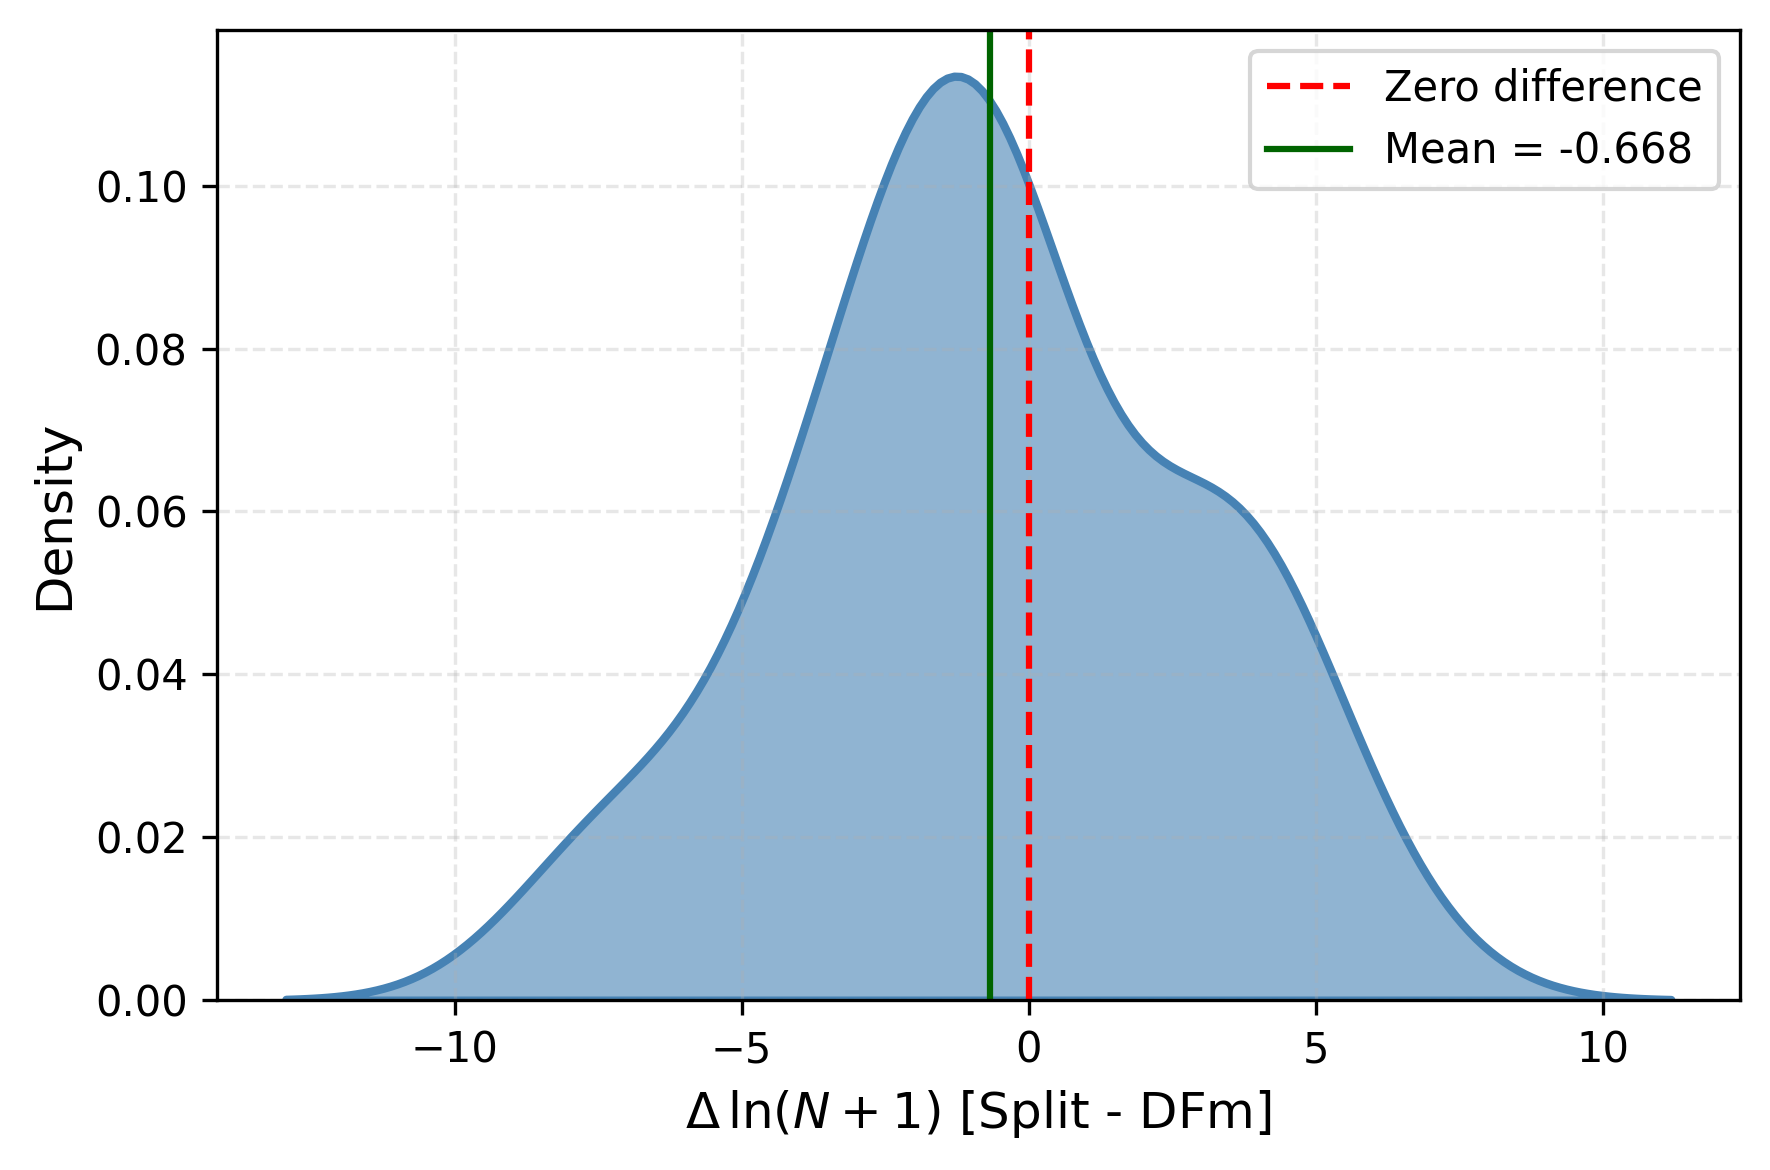


Summary Statistics:
Min: -7.8433
25th percentile: -2.7216
Median: -0.9589
75th percentile: 1.8718
Max: 6.0885

Instances where Split > DFm: 11 (32.4%)
Instances where Split < DFm: 23 (67.6%)
Instances where Split = DFm: 0 (0.0%)


In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

# KDE plot
sns.kdeplot(log_diff, ax=ax, fill=True, color='steelblue', alpha=0.6, linewidth=2)

# Add vertical lines
ax.axvline(0, color='red', linestyle='--', linewidth=1.5, label='Zero difference')
ax.axvline(log_diff.mean(), color='darkgreen', linestyle='-', linewidth=1.5,
           label=f'Mean = {log_diff.mean():.3f}')

# Labels and formatting
ax.set_xlabel(r'$\Delta \, \ln(N + 1)$ [Split - DFm]', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.legend(frameon=True, fontsize=10)
ax.grid(alpha=0.3, linestyle='--')

fig.tight_layout()
plt.savefig('log-diff-distribution-dfm.pdf', bbox_inches='tight')
plt.show()

# Summary statistics
print(f"\nSummary Statistics:")
print(f"==================")
print(f"Min: {log_diff.min():.4f}")
print(f"25th percentile: {log_diff.quantile(0.25):.4f}")
print(f"Median: {log_diff.median():.4f}")
print(f"75th percentile: {log_diff.quantile(0.75):.4f}")
print(f"Max: {log_diff.max():.4f}")
print(f"\nInstances where Split > DFm: {(log_diff > 0).sum()} ({100 * (log_diff > 0).sum() / len(log_diff):.1f}%)")
print(f"Instances where Split < DFm: {(log_diff < 0).sum()} ({100 * (log_diff < 0).sum() / len(log_diff):.1f}%)")
print(f"Instances where Split = DFm: {(log_diff == 0).sum()} ({100 * (log_diff == 0).sum() / len(log_diff):.1f}%)")